# 評価基準とスコア

これまではクラス分類性のを精度（正確に分類されたサンプルの割合）で、回帰性能をR2で評価してきた。しかしこれらは、あるデータに対する教師あり学習モデルの性能を１つの数値にまとめる手法の２例でしかない。

### 最終的な目的を見失わないこと

- `ビジネス評価基準`: 機械学習の基準を選ぶ前に，そのアプリケーションの高レベルの目的
- `ビジネスインパクト`: 機械学習アプリケーションに対して，特定のアルゴリズムを選択した結果

### 2クラス分類における基準

２つのクラスを`陽性`,`陰性`と呼び，探している物を陽性と呼ぶ．

#### エラーの種類

- `偽陽性`: 陰性のものを陽性と間違えること
- `偽陰性`: 陽性のものを陰性と間違えること

例) 癌を陽性としたとき，偽陽性は健康的な人を癌と判断すること，偽陰性は癌患者を健康と判断すること

この場合偽陰性が出るのは可能な限り避けるべき

#### 偏ったデータセット

In [8]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

digits = load_digits()
y = digits.target == 9

X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=0)

- ダミーモデル

In [9]:
from sklearn.dummy import DummyClassifier
import numpy as np
dummy_majority = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
pred_most_frequent = dummy_majority.predict(X_test)
print("Unique predicted labels: {}".format(np.unique(pred_most_frequent)))
print("Test score: {:.2f}".format(dummy_majority.score(X_test, y_test)))

Unique predicted labels: [False]
Test score: 0.90


全部falseと予測してるのに90%の精度が出る

- class sklearn.dummy.DummyClassifier(strategy=’stratified’, random_state=None, constant=None)

Parameters:	

strategy : str, default=”stratified”

    Strategy to use to generate predictions.

        “stratified”: generates predictions by respecting the training set’s class distribution.層別分析：各分割層内でのクラスの比率が全体の比率と同じになるように分割する。

        “most_frequent”: always predicts the most frequent label in the training set.

        “prior”: always predicts the class that maximizes the class prior (like “most_frequent”) and predict_proba returns the class prior.

        “uniform”: generates predictions uniformly at random.

        “constant”: always predicts a constant label that is provided by the user. This is useful for metrics that evaluate a non-majority class

        New in version 0.17: Dummy Classifier now supports prior fitting strategy using parameter prior.

-  score(X, y, sample_weight=None)[source]

    Returns the mean accuracy(平均精度) on the given test data and labels.

    In multi-label classification, this is the subset accuracy which is a harsh metric since you require for each sample that each label set be correctly predicted.
    Parameters:	

    X : array-like, shape = (n_samples, n_features)

        Test samples.

    y : array-like, shape = (n_samples) or (n_samples, n_outputs)

        True labels for X.

    sample_weight : array-like, shape = [n_samples], optional

        Sample weights.

    Returns:	

    score : float

        Mean accuracy of self.predict(X) wrt. y.
        
        
精度：正確な予測の数をすべてのサンプルの数で割ったもの。



- 決定木

    - score=平均精度

In [10]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth=2).fit(X_train, y_train)
pred_tree = tree.predict(X_test)
print("Test score: {:.2f}".format(tree.score(X_test, y_test)))

Test score: 0.92


ダミーモデルも決定木も成績が良すぎる！！！

そこでダミーモデルの層化分類を行っていないディフォルトとロジスティック回帰を使ってみよう。

In [11]:
from sklearn.linear_model import LogisticRegression

dummy = DummyClassifier().fit(X_train, y_train)
pred_dummy = dummy.predict(X_test)
print("dummy score: {:.2f}".format(dummy.score(X_test, y_test)))

logreg = LogisticRegression(C=0.1).fit(X_train, y_train)
pred_logreg = logreg.predict(X_test)
print("logreg score: {:.2f}".format(logreg.score(X_test, y_test)))

dummy score: 0.84
logreg score: 0.98


- どのモデルで行っても成績は抜群だ！

    - 偏ったデータに対する評価として精度が不適切だとわかる！！！
    
    - 精度が高いものを返すだけのクラス分類器　pred_most_frequent
    
    - ランダムなクラス分類器 pred_dummy
よりも良いモデルがほしい。


#### 混合行列

2クラス分類の評価結果を表現する方法で，最も包括的な方法の一つ

In [12]:
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(y_test, pred_logreg)
print("Confusion matrix:\n{}".format(confusion))

Confusion matrix:
[[401   2]
 [  8  39]]


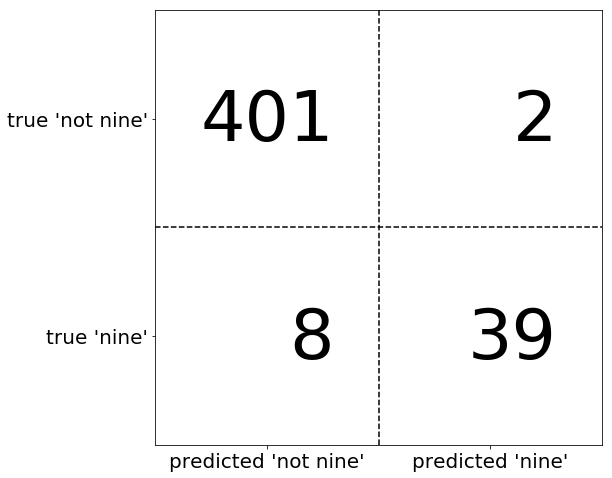

In [13]:
import mglearn
import matplotlib.pyplot as plt

mglearn.plots.plot_confusion_matrix_illustration()
plt.show()


- 陽性：探しているもの(癌である患者)
- 陰性：陽性以外(癌でない患者)

- `真陽性`: 陽性クラスと正しく分類されたサンプル(癌の患者を癌と判断する)
- `真陰性`: 陰性クラスと正しく分類されたサンプル(癌でない患者を癌でないと判断した)

- `為陽性(ぎようせい)`: 偽性クラスと間違って分類されたサンプル(癌でない患者を癌と判断した)
- `為陰性(ぎいんせい)`: 陽性クラスと間違って分類されたサンプル(癌の患者を癌でないと判断した)

###### 9の例

- 401個が９でない数字を９でないと判断した
- 2個が９でない数字を９と判断した
- ８個が９であるのに９でないと判断した
- ３９個が９を９と判断した。


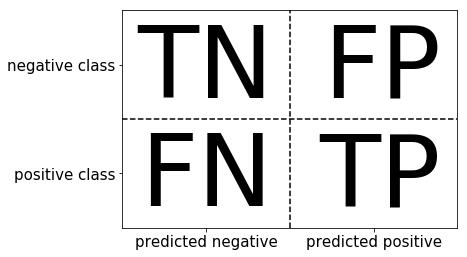

In [14]:
mglearn.plots.plot_binary_confusion_matrix()
plt.show()

In [15]:
print("Most frequent class:")
print(confusion_matrix(y_test, pred_most_frequent))
print("\nDummy model:")
print(confusion_matrix(y_test, pred_dummy))
print("\nDecision tree:")
print(confusion_matrix(y_test, pred_tree))
print("\nLogistic Regression")
print(confusion_matrix(y_test, pred_logreg))

Most frequent class:
[[403   0]
 [ 47   0]]

Dummy model:
[[365  38]
 [ 41   6]]

Decision tree:
[[390  13]
 [ 24  23]]

Logistic Regression
[[401   2]
 [  8  39]]


`精度(Accuracy)`

\begin{equation}
\text{Accuracy} = \frac{\text{TP} + \text{TN}}{\text{TP} + \text{TN} + \text{FP} + \text{FN}}
\end{equation}

`適合率(Precision)`

陽性と予測されたものがどのくらい実際に陽性であったかの測定．
偽陽性の数を制限したいときに用いる．

癌であると予測された患者が、実際にどれくらい癌であったかを計算。癌である患者を癌でないと判断するリスクを軽減。

有効であると予測された新薬が、実際にどれくらい有効であったかを計算。有効である薬を有効でないと判断するリスクを軽減。

'これだと本文に疑問あり？'

- `真陽性(true positive)`: 陽性クラスと正しく分類されたサンプル(癌の患者を癌と判断する)
- `真陰性(true negative)`: 陰性クラスと正しく分類されたサンプル(癌でない患者を癌でないと判断した)

- `為陽性(false positive)`: 陽性クラスと間違って分類されたサンプル(癌でない患者を癌と判断した)
- `為陰性(false negative)`: 陰性クラスと間違って分類されたサンプル(癌の患者を癌でないと判断した)

- 分母：TP+FP＝癌の患者を癌と判断+癌でない患者を癌と判断＝検査に参加した人の中での癌と予測された患者数
- 分子：TP=癌の患者と判断

- 観測結果・サンプルの中にどれくらい正解があるかを調べている。

\begin{equation}
\text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}
\end{equation}

`再現率(Recall)`

実際に陽性のサンプルのうち陽性と予測されたものの割合
偽陰性の数を制限したいときに用いる．

実際に癌の患者が癌と予測される割合
癌でない患者を癌と判断するリスクを軽減

- 分母：TP+FN＝癌の患者を癌と判断+癌の患者を癌でないと判断＝検査に参加した人の中での癌の患者数
- 分子：TP=癌の患者と判断

- 正解の母集団のうちどの程度の正解が観測結果・サンプルに含まれているを調べている。


例)癌判断

\begin{equation}
\text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}}
\end{equation}

`F値`

適合率と再現率の双方を取り入れている

\begin{eqnarray}
\text{F} &=& 2 \cdot \frac{\text{precision} \cdot \text{recall}}{\text{precision} + \text{recall}}\\
&=& \frac{TP}{TP+FP+TP+FN}
\end{eqnarray}

In [16]:
from sklearn.metrics import f1_score

print("f1 score most frequent: {:.2f}".format(f1_score(y_test, pred_most_frequent)))
print("f1 score dummy: {:.2f}".format(f1_score(y_test, pred_dummy)))
print("f1 score tree: {:.2f}".format(f1_score(y_test, pred_tree)))
print("f1 score logistic regression: {:.2f}".format(f1_score(y_test, pred_logreg)))

f1 score most frequent: 0.00
f1 score dummy: 0.13
f1 score tree: 0.55
f1 score logistic regression: 0.89


/home/moriya/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [17]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_most_frequent,target_names=["not nine", "nine"]))

             precision    recall  f1-score   support

   not nine       0.90      1.00      0.94       403
       nine       0.00      0.00      0.00        47

avg / total       0.80      0.90      0.85       450



/home/moriya/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [18]:
print(classification_report(y_test, pred_dummy,target_names=["not nine", "nine"]))

             precision    recall  f1-score   support

   not nine       0.90      0.91      0.90       403
       nine       0.14      0.13      0.13        47

avg / total       0.82      0.82      0.82       450



In [19]:
print(classification_report(y_test, pred_logreg,target_names=["not nine", "nine"]))

             precision    recall  f1-score   support

   not nine       0.98      1.00      0.99       403
       nine       0.95      0.83      0.89        47

avg / total       0.98      0.98      0.98       450



#### 不確実性を考慮に入れる

- 決定関数(Decision function)

あるデータポイントが陽性であるとモデルが信じている度合いを示している。

- 確率の予測(predict_proba)

    - 決定木：訓練時にノードごとに作成されるクラスラベルの頻度ベクトルから確率が計算される。ベクトルには、そのノードにおけるクラスラベルの分布から計算された各クラスラベルの頻度値が格納される。頻度は１になるように正規化される。
    - ｋ-近傍アルゴリズム：クラスラベルの頻度を正規化
    
    これらは確率密度関数から導き出されていないことに注意
    
    
###### 過剰適合したモデルは、間違っている場合でさえ、高い確率で予測する傾向にある。
###### 複雑さが低いモデルの予測は確信度(確率)が低い。？？？
###### あるモデルが報告する確信度が、実際の正答率と一致している場合、較正

In [40]:
from mglearn.datasets import make_blobs
from sklearn.svm import SVC
X, y = make_blobs(n_samples=(400, 50), centers=2, cluster_std=[7.0, 2],
                  random_state=22)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
svc = SVC(gamma=.05).fit(X_train, y_train)

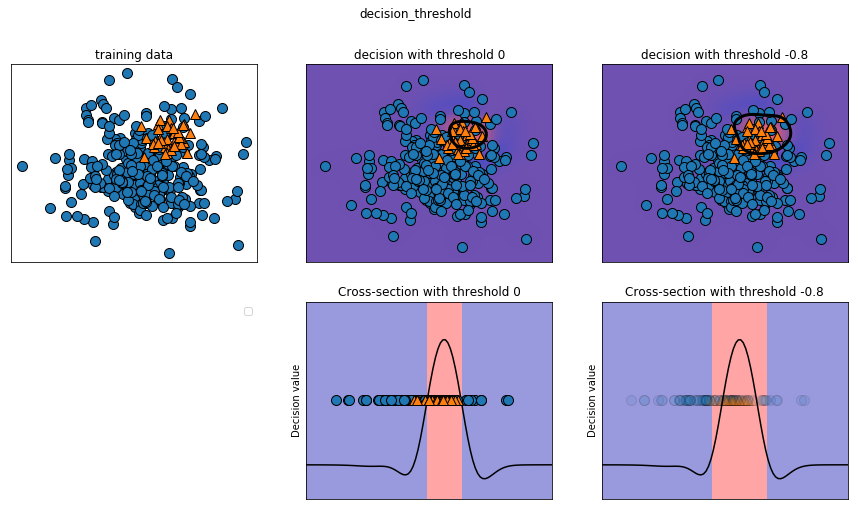

In [41]:
mglearn.plots.plot_decision_threshold()
plt.show()

In [42]:
print(classification_report(y_test, svc.predict(X_test)))

             precision    recall  f1-score   support

          0       0.97      0.89      0.93       104
          1       0.35      0.67      0.46         9

avg / total       0.92      0.88      0.89       113



In [43]:
y_pred_lower_threshold = svc.decision_function(X_test) > -.8

In [44]:
print(classification_report(y_test, y_pred_lower_threshold))

             precision    recall  f1-score   support

          0       1.00      0.82      0.90       104
          1       0.32      1.00      0.49         9

avg / total       0.95      0.83      0.87       113



#### 適合率- 再現率カーブとROCカーブ

In [45]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, svc.decision_function(X_test))

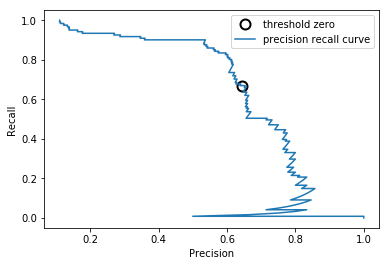

In [46]:
X, y = make_blobs(n_samples=(4000, 500), centers=2, cluster_std=[7.0, 2], random_state=22)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
svc = SVC(gamma=.05).fit(X_train, y_train)
precision, recall, thresholds = precision_recall_curve(y_test, svc.decision_function(X_test))

close_zero = np.argmin(np.abs(thresholds))
plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10,
         label="threshold zero", fillstyle="none", c='k', mew=2)

plt.plot(precision, recall, label="precision recall curve")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend(loc="best")
plt.show()

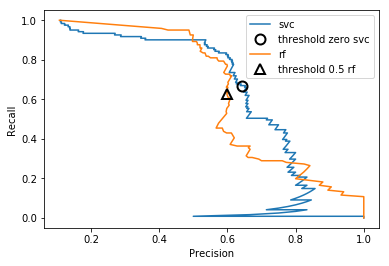

In [27]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=0, max_features=2)
rf.fit(X_train, y_train)

precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test, rf.predict_proba(X_test)[:, 1])

plt.plot(precision, recall, label="svc")

plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10, label="threshold zero svc", fillstyle="none", c='k', mew=2)

plt.plot(precision_rf, recall_rf, label="rf")

close_default_rf = np.argmin(np.abs(thresholds_rf - 0.5))
plt.plot(precision_rf[close_default_rf], recall_rf[close_default_rf], '^', c='k', markersize=10, label="threshold 0.5 rf", fillstyle="none", mew=2)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend(loc="best")
plt.show()

In [28]:
print("f1_score of random forest: {:.3f}".format(f1_score(y_test, rf.predict(X_test))))
print("f1_score of svc: {:.3f}".format(f1_score(y_test, svc.predict(X_test))))

f1_score of random forest: 0.610
f1_score of svc: 0.656


In [29]:
from sklearn.metrics import average_precision_score
ap_rf = average_precision_score(y_test, rf.predict_proba(X_test)[:, 1])
ap_svc = average_precision_score(y_test, svc.decision_function(X_test))
print("Average precision of random forest: {:.3f}".format(ap_rf))
print("Average precision of svc: {:.3f}".format(ap_svc))

Average precision of random forest: 0.660
Average precision of svc: 0.666


#### 受信者動作特性(ROC)とAUC

様々なスレッショルドにおけるクラス分類機の挙動を解析するための道具としてROCカーブというものがある．

- `真陽性(true positive)`: 陽性クラスと正しく分類されたサンプル(癌の患者を癌と判断する)
- `真陰性(true negative)`: 陰性クラスと正しく分類されたサンプル(癌でない患者を癌でないと判断した)

- `為陽性(false positive)`: 陽性クラスと間違って分類されたサンプル(癌でない患者を癌と判断した)
- `為陰性(false negative)`: 陰性クラスと間違って分類されたサンプル(癌の患者を癌でないと判断した)

- 分母：癌でない患者を癌と判断した＋癌でない患者を癌でないと判断した＝癌でない患者
− 分子：癌でない患者を癌と判断した。

癌でない患者を癌と判断した割合


\begin{equation}
\text{FPR} = \frac{\text{FP}}{\text{FP} + \text{TN}}
\end{equation}

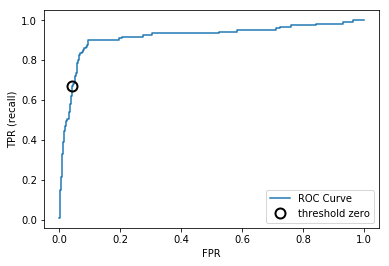

In [30]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, svc.decision_function(X_test))

plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,label="threshold zero", fillstyle="none", c='k', mew=2)
plt.legend(loc=4)
plt.show()

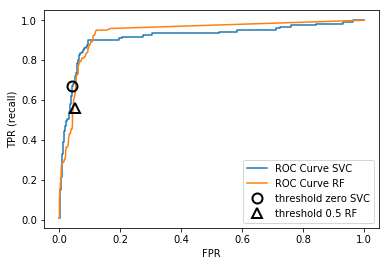

In [31]:
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])

plt.plot(fpr, tpr, label="ROC Curve SVC")
plt.plot(fpr_rf, tpr_rf, label="ROC Curve RF")

plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10, label="threshold zero SVC", fillstyle="none", c='k', mew=2)
close_default_rf = np.argmin(np.abs(thresholds_rf - 0.5))
plt.plot(fpr_rf[close_default_rf], tpr[close_default_rf], '^', markersize=10, label="threshold 0.5 RF", fillstyle="none", c='k', mew=2)

plt.legend(loc=4)
plt.show()

In [32]:
from sklearn.metrics import roc_auc_score
rf_auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
svc_auc = roc_auc_score(y_test, svc.decision_function(X_test))
print("AUC for Random Forest: {:.3f}".format(rf_auc))
print("AUC for SVC: {:.3f}".format(svc_auc))

AUC for Random Forest: 0.937
AUC for SVC: 0.916


gamma = 1.00  accuracy = 0.90  AUC = 0.50
gamma = 0.05  accuracy = 0.90  AUC = 1.00
gamma = 0.01  accuracy = 0.90  AUC = 1.00


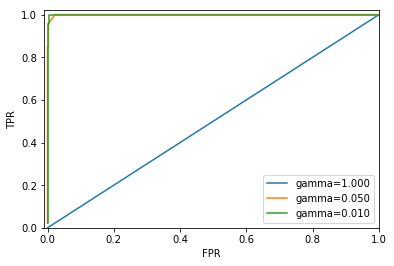

In [33]:
y = digits.target == 9

X_train, X_test, y_train, y_test = train_test_split(
    digits.data, y, random_state=0)

plt.figure()

for gamma in [1, 0.05, 0.01]:
    svc = SVC(gamma=gamma).fit(X_train, y_train)
    accuracy = svc.score(X_test, y_test)
    auc = roc_auc_score(y_test, svc.decision_function(X_test))
    fpr, tpr, _ = roc_curve(y_test , svc.decision_function(X_test))
    print("gamma = {:.2f}  accuracy = {:.2f}  AUC = {:.2f}".format(gamma, accuracy, auc))
    plt.plot(fpr, tpr, label="gamma={:.3f}".format(gamma))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.xlim(-0.01, 1)
plt.ylim(0, 1.02)
plt.legend(loc="best")
plt.show()

### 多クラス分類の基準

- 最初のクラスで他の数字に間違えられたものはなかったー＞偽陰性ー＞最初の行がほかは全てゼロ

- 他のクラスでゼロと判断されたものはなかったー＞偽陽性ー＞最初の列がほかは全てゼロ

In [34]:
from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, random_state=0)
lr = LogisticRegression().fit(X_train, y_train)
pred = lr.predict(X_test)
print("Accuracy: {:.3f}".format(accuracy_score(y_test, pred)))
print("Confusion matrix:\n{}".format(confusion_matrix(y_test, pred)))

Accuracy: 0.953
Confusion matrix:
[[37  0  0  0  0  0  0  0  0  0]
 [ 0 39  0  0  0  0  2  0  2  0]
 [ 0  0 41  3  0  0  0  0  0  0]
 [ 0  0  1 43  0  0  0  0  0  1]
 [ 0  0  0  0 38  0  0  0  0  0]
 [ 0  1  0  0  0 47  0  0  0  0]
 [ 0  0  0  0  0  0 52  0  0  0]
 [ 0  1  0  1  1  0  0 45  0  0]
 [ 0  3  1  0  0  0  0  0 43  1]
 [ 0  0  0  1  0  1  0  0  1 44]]


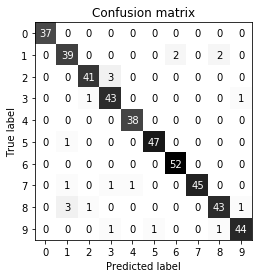

In [35]:
scores_image = mglearn.tools.heatmap(
    confusion_matrix(y_test, pred), xlabel='Predicted label',
    ylabel='True label', xticklabels=digits.target_names,
    yticklabels=digits.target_names, cmap=plt.cm.gray_r, fmt="%d")
plt.title("Confusion matrix")
plt.gca().invert_yaxis()
plt.show()

In [36]:
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        37
          1       0.89      0.91      0.90        43
          2       0.95      0.93      0.94        44
          3       0.90      0.96      0.92        45
          4       0.97      1.00      0.99        38
          5       0.98      0.98      0.98        48
          6       0.96      1.00      0.98        52
          7       1.00      0.94      0.97        48
          8       0.93      0.90      0.91        48
          9       0.96      0.94      0.95        47

avg / total       0.95      0.95      0.95       450



### 回帰の基準

##### すべての回帰器でscoreメソッドのディフォルトである$R^2$を用いれば十分であった。---ありえない？？？


#### 評価基準を用いたモデル選択

In [37]:
from sklearn.model_selection import cross_val_score

print("Default scoring: {}".format(cross_val_score(SVC(), digits.data, digits.target == 9)))
explicit_accuracy =  cross_val_score(SVC(), digits.data, digits.target == 9, scoring="accuracy")
print("Explicit accuracy scoring: {}".format(explicit_accuracy))
roc_auc =  cross_val_score(SVC(), digits.data, digits.target == 9, scoring="roc_auc")
print("AUC scoring: {}".format(roc_auc))

Default scoring: [ 0.89983306  0.89983306  0.89983306]
Explicit accuracy scoring: [ 0.89983306  0.89983306  0.89983306]
AUC scoring: [ 0.99372294  0.98957947  0.99594929]


In [38]:
from sklearn.model_selection import GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target == 9, random_state=0)

param_grid = {'gamma': [0.0001, 0.01, 0.1, 1, 10]}

grid = GridSearchCV(SVC(), param_grid=param_grid)
grid.fit(X_train, y_train)
print("Grid-Search with accuracy")
print("Best parameters:", grid.best_params_)
print("Best cross-validation score (accuracy)): {:.3f}".format(grid.best_score_))
print("Test set AUC: {:.3f}".format(roc_auc_score(y_test, grid.decision_function(X_test))))
print("Test set accuracy: {:.3f}".format(grid.score(X_test, y_test)))

grid = GridSearchCV(SVC(), param_grid=param_grid, scoring="roc_auc")
grid.fit(X_train, y_train)
print("\nGrid-Search with AUC")
print("Best parameters:", grid.best_params_)
print("Best cross-validation score (AUC): {:.3f}".format(grid.best_score_))
print("Test set AUC: {:.3f}".format(roc_auc_score(y_test, grid.decision_function(X_test))))
print("Test set accuracy: {:.3f}".format(grid.score(X_test, y_test)))

Grid-Search with accuracy
Best parameters: {'gamma': 0.0001}
Best cross-validation score (accuracy)): 0.970
Test set AUC: 0.992
Test set accuracy: 0.973

Grid-Search with AUC
Best parameters: {'gamma': 0.01}
Best cross-validation score (AUC): 0.997
Test set AUC: 1.000
Test set accuracy: 1.000


In [39]:
from sklearn.metrics.scorer import SCORERS
print("Available scorers:\n{}".format(sorted(SCORERS.keys())))

Available scorers:
['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'log_loss', 'mean_absolute_error', 'mean_squared_error', 'median_absolute_error', 'mutual_info_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'normalized_mutual_info_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'v_measure_score']
